In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install keras==2.3.1
!pip install tensorflow_gpu==2.1.0
!apt-get -qq install -y graphviz && pip install -q pydot
!pip install h5py==2.10.0 

In [ ]:
import glob
import os
import time

import random
import numpy as np
from numpy import asarray
import pandas as pd
from itertools import repeat

import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard ,ModelCheckpoint
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense, Conv2D, UpSampling2D
from keras.models import Model,load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model


import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt

import pydot
from IPython.display import Image as IPythonImage

import warnings
warnings.filterwarnings("ignore")

2021-12-26 08:13:38.677448: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-12-26 08:13:38.678576: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-12-26 08:13:38.678646: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Using TensorFlow backend.


In [ ]:
print("Tensorflow version " + tf.__version__)
print("Keras version " + tf.keras.__version__)

Tensorflow version 2.1.0
Keras version 2.2.4-tf


In [ ]:
%%capture
!gdown --id 1FecqM21TKwI1GXtL8YOG0bm_x907tXgd
!unzip /content/high_resolution.zip
!rm /content/high_resolution.zip

# !gdown --id 1kxv-c2nfwfnkH6bn1JW7VnXa-LoNUYTx
# !unzip /content/cloth.zip
# !rm /content/cloth.zip

!rm /content/high_resolution/desktop.ini

In [ ]:
# use seed for reproducible results
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
data_path = r'/content/'
Saved_model_Path="/content/drive/MyDrive/Output/Try23_12_2021__Abdullah"
CLASSES_List=["high_resolution"]

epochs = 5001 

# batch size equals to 8 (due to RAM limits)
batch_size = 4

# define the shape of low resolution image (LR) 
low_resolution_shape = (64, 64, 3)

# define the shape of high resolution image (HR) 
high_resolution_shape = (256, 256, 3)

# optimizer for discriminator, generator 
common_optimizer = Adam(0.0002, 0.9) 

#load the pretrained model VGG , trained on imagenet data
VGG19_base = VGG19(weights="imagenet")

574717952/574710816 [==============================] - 38s 0us/step


In [ ]:
def get_train_images():
    CLASSES = CLASSES_List
    image_list = []
    for class_type in CLASSES:
        image_list.extend(glob.glob(data_path + class_type + '/*'))
    return image_list    


def find_img_dims(image_list):
    
    min_size = []
    max_size = []
    
    for i in range(len(image_list)):
        im = Image.open(image_list[i])
        min_size.append(min(im.size))
        max_size.append(max(im.size))    
    return min(min_size), max(max_size)

def compute_psnr(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
    psnr = tf.image.psnr(original_image, generated_image, max_val=1.0)

    return tf.math.reduce_mean(psnr, axis=None, keepdims=False, name=None)

def plot_psnr(psnr):
    psnr_means = psnr['psnr_quality']
    plt.figure(figsize=(10,8))
    plt.plot(psnr_means)    
    plt.xlabel('Epochs')
    plt.ylabel('PSNR') 
    plt.title('PSNR')

def compute_ssim(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
    ssim = tf.image.ssim(original_image, generated_image, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

    return tf.math.reduce_mean(ssim, axis=None, keepdims=False, name=None)

def plot_ssim(ssim):
    
    ssim_means = ssim['ssim_quality']

    plt.figure(figsize=(10,8))
    plt.plot(ssim_means)
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.title('SSIM')

def plot_loss(losses):

    d_loss = losses['d_history']
    g_loss = losses['g_history']
    
   
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss")    
    plt.legend()



def sample_images(image_list):
    
    """
    Pre-process a batch of training images
    """
    
    # image_list is the list of all images
    # ransom sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    

    for img in images_batch:
  
        img1 = imread(img, as_gray=False, pilmode='RGB')
        #img1 = imread(img, pilmode='RGB')
        img1 = img1.astype(np.float32)
        
        # change the size     
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)
                

        # do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)
       
        hr_images.append(img1_high_resolution)
        lr_images.append(img1_low_resolution)
        
   
    # convert lists into numpy ndarrays
    return np.array(hr_images), np.array(lr_images)    


def save_images(original_image, lr_image, sr_image, path):
    
    """
    Save LR, HR (original) and generated SR
    images in one panel 
    """
    
    fig, ax = plt.subplots(1,3, figsize=(10, 6))

    images = [original_image, lr_image, sr_image]
    titles = ['HR', 'LR','SR - generated']

    for idx,img in enumerate(images):
        # (X + 1)/2 to scale back from [-1,1] to [0,1]
        ax[idx].imshow((img + 1)/2.0, cmap='gray')
        ax[idx].axis("off")
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title))
        
    plt.savefig(path)    



def residual_block(x):

    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Add()([res, x])
    
    return res


def build_generator():
    
    # use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    
    # input LR dimension: 4x downsample of HR
    input_shape = (64, 64, 3)
    
    # input for the generator
    input_layer = Input(shape=input_shape)
    
    # pre-residual block: conv layer before residual blocks 
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    
    # add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    
    # post-residual block: conv and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    
    # take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    
    # upsampling
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    
    # upsampling
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    
    # conv layer at the output
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    
    # model 
    model = Model(inputs=[input_layer], outputs=[output], name='generator')

    return model


def build_discriminator():
    
    # define hyperparameters
    leakyrelu_alpha = 0.2
    momentum = 0.8
    
    # the input is the HR shape
    input_shape = (256, 256, 3)
    
    # input layer for discriminator
    input_layer = Input(shape=input_shape)
    
    # 8 convolutional layers with batch normalization  
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    
    # fully connected layer 
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    
    # last fully connected layer - for classification 
    output = Dense(units=1, activation='sigmoid')(dis9)   
    
    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    
    return model


def build_VGG19():
    
    input_shape = (256, 256, 3)
    VGG19_base.outputs = [VGG19_base.get_layer('block5_conv2').output]
    input_layer = Input(shape=input_shape)
    #list of layer objects that are specified by layer names
    #layer that make generation
    features = VGG19_base(input_layer)
    #create the model that outputs content  and style are specified by layer names
    model = Model(inputs=[input_layer], outputs=[features])
    
    return model


def build_adversarial_model(generator, discriminator, feature_extractor):
    
    # input layer for high-resolution images
    input_high_resolution = Input(shape=high_resolution_shape)

    # input layer for low-resolution images
    input_low_resolution = Input(shape=low_resolution_shape)

    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator(input_low_resolution)

    # extract feature maps from generated images
    features = feature_extractor(generated_high_resolution_images)
    
    # make a discriminator non-trainable 
    discriminator.trainable = False
    discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

    # discriminator will give us a probability estimation for the generated high-resolution images
    probs = discriminator(generated_high_resolution_images)

    # create and compile 
    adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
    adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)
    
    return adversarial_model




# training loop
def train(epochs=epochs , batch_size=batch_size):
  losses = {"d_history":[], "g_history":[]}
  psnr = {'psnr_quality': []}
  ssim = {'ssim_quality': []}

  generator = build_generator()
  discriminator = build_discriminator()
  discriminator.trainable = True
  discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

  fe_model = build_VGG19()
  fe_model.trainable = False
  fe_model.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

  adversarial = build_adversarial_model(generator, discriminator, fe_model)

  for epoch in range(epochs):

      print("Epoch {}/{}".format(epoch+1 ,epochs)) 

      d_history = []
      g_history = []
      
      image_list = get_train_images()
      
      """
      Train the discriminator network
      """
      
      hr_images, lr_images = sample_images(image_list)
      
      
      # normalize the images
      hr_images = hr_images / 127.5 - 1.
      lr_images = lr_images / 127.5 - 1.
      
      # generate high-resolution images from low-resolution images
      generated_high_resolution_images = generator.predict(lr_images)
      
      # generate a batch of true and fake labels 
      real_labels = np.ones((batch_size, 16, 16, 1))
      fake_labels = np.zeros((batch_size, 16, 16, 1))
      
  
      d_loss_real = discriminator.train_on_batch(hr_images, real_labels)
      d_loss_real =  np.mean(d_loss_real)
      d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)
      d_loss_fake =  np.mean(d_loss_fake)
      
      # calculate total loss of discriminator as average loss on true and fake labels
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      losses['d_history'].append(d_loss)
    

      """
          Train the generator network
      """
      
      # extract feature maps for true high-resolution images
      image_features = fe_model.predict(hr_images)


      
      # train the generator
      g_loss = adversarial.train_on_batch([lr_images, hr_images],
                                                [real_labels, image_features])
      
      losses['g_history'].append(0.5 * (g_loss[1]))
      
      
      
      # calculate the psnr  
      ps = compute_psnr(hr_images, generated_high_resolution_images) 
      psnr['psnr_quality'].append(ps)
              
      # calculate the ssim 
      ss = compute_ssim(hr_images, generated_high_resolution_images)   
      ssim['ssim_quality'].append(ss)

      
      #################################
      # Losses
      print(f"@Epoch: {epoch+1}\tD_loss: {d_loss}\tG_loss: {g_loss}\tPSNR:{ps}\tSSIM:{ss}")
      print("__"*15) 
      ################################
      """
          save and print image samples
      """
      
      if epoch % 500 == 0:
          generator.save(Saved_model_Path+f"/generator_{epoch}.h5")

          generated_images = generator.predict_on_batch(lr_images)
      
          for index, img in enumerate(generated_images):
              if index < 3:   # comment this line to display all the images
                  save_images(hr_images[index], lr_images[index], img,
                              path=Saved_model_Path +"/img_{}_{}".format(epoch, index)) 
       

  return generator ,discriminator,adversarial,losses,psnr,ssim



def sample_images_test(img):

    
    lr_images = []
    
    img1 = imread(img, as_gray=False, pilmode='RGB')
    img1 = img1.astype(np.float32)
    
    img1_low_resolution = imresize(img1, (64, 64, 3))
          

    # do a random horizontal flip
    if np.random.random() < 0.5:
        img1_low_resolution = np.fliplr(img1_low_resolution)
    
    lr_images.append(img1_low_resolution)
        
   
    # convert lists into numpy ndarrays
    return  np.array(lr_images)    

def save_images_test(original_image , sr_image, saved_path):
    
    """
    Save LR, HR (original) and generated SR
    images in one panel 
    """
    
    fig, ax = plt.subplots(1,2, figsize=(10, 6))

    images = [original_image, sr_image]
    titles = ['OR','SR']

    for idx,img in enumerate(images):
        # (X + 1)/2 to scale back from [-1,1] to [0,1]
        ax[idx].imshow((img + 1)/2.0, cmap='gray')
        ax[idx].axis("off")
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title))
        
    plt.savefig(saved_path)  

	
	
def SRGAN_predict(lr_image_path, model_path): 
  img =lr_image_path  
  lr_images = sample_images_test(img) 
  # normalize the images 
  lr_images = lr_images / 127.5 - 1. 
  model=load_model(model_path) 
  generated_images = model.predict_on_batch(lr_images) 
  lr_images2 = lr_images.reshape((64,64,3)) 
  generated_images2= generated_images.reshape((256,256,3)) 
  return lr_images2,generated_images2
  
  

  
def show_image(img):
	_, axs = plt.subplots(1, 1, figsize=(5, 5))
	axs.imshow((img + 1)/2.0, cmap='gray')
	plt.show()
	  

In [ ]:
# get min/max image sizes
image_list = get_train_images()
min_size, max_size = find_img_dims(image_list)
print('The min and max image dims are {} and {} respectively.'
      .format(min_size, max_size))

The min and max image dims are 256 and 5380 respectively.


In [ ]:
generator = build_generator()

discriminator = build_discriminator()
discriminator.trainable = True
discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

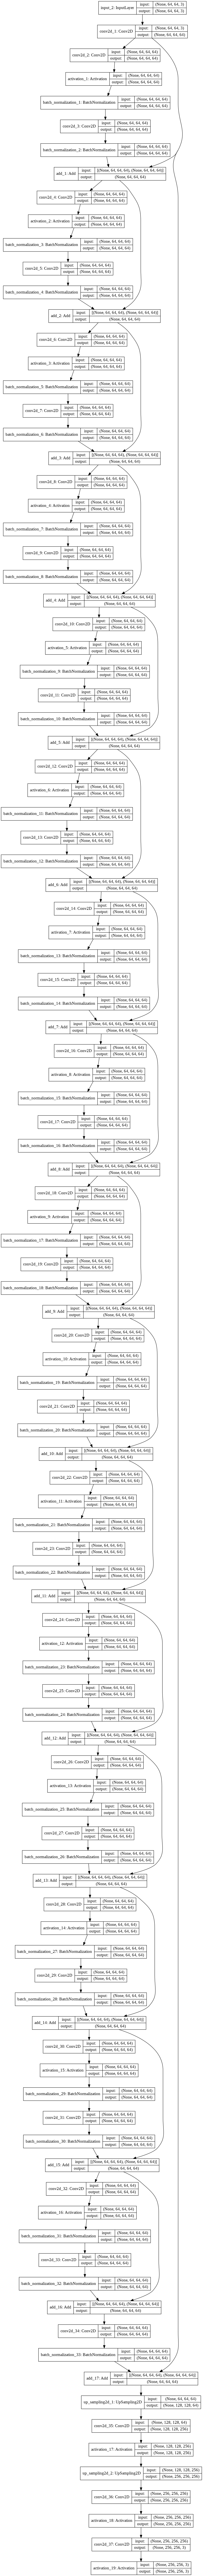

In [ ]:
plot_model(generator, to_file="generator.png", show_shapes=True)
display(IPythonImage('generator.png'))

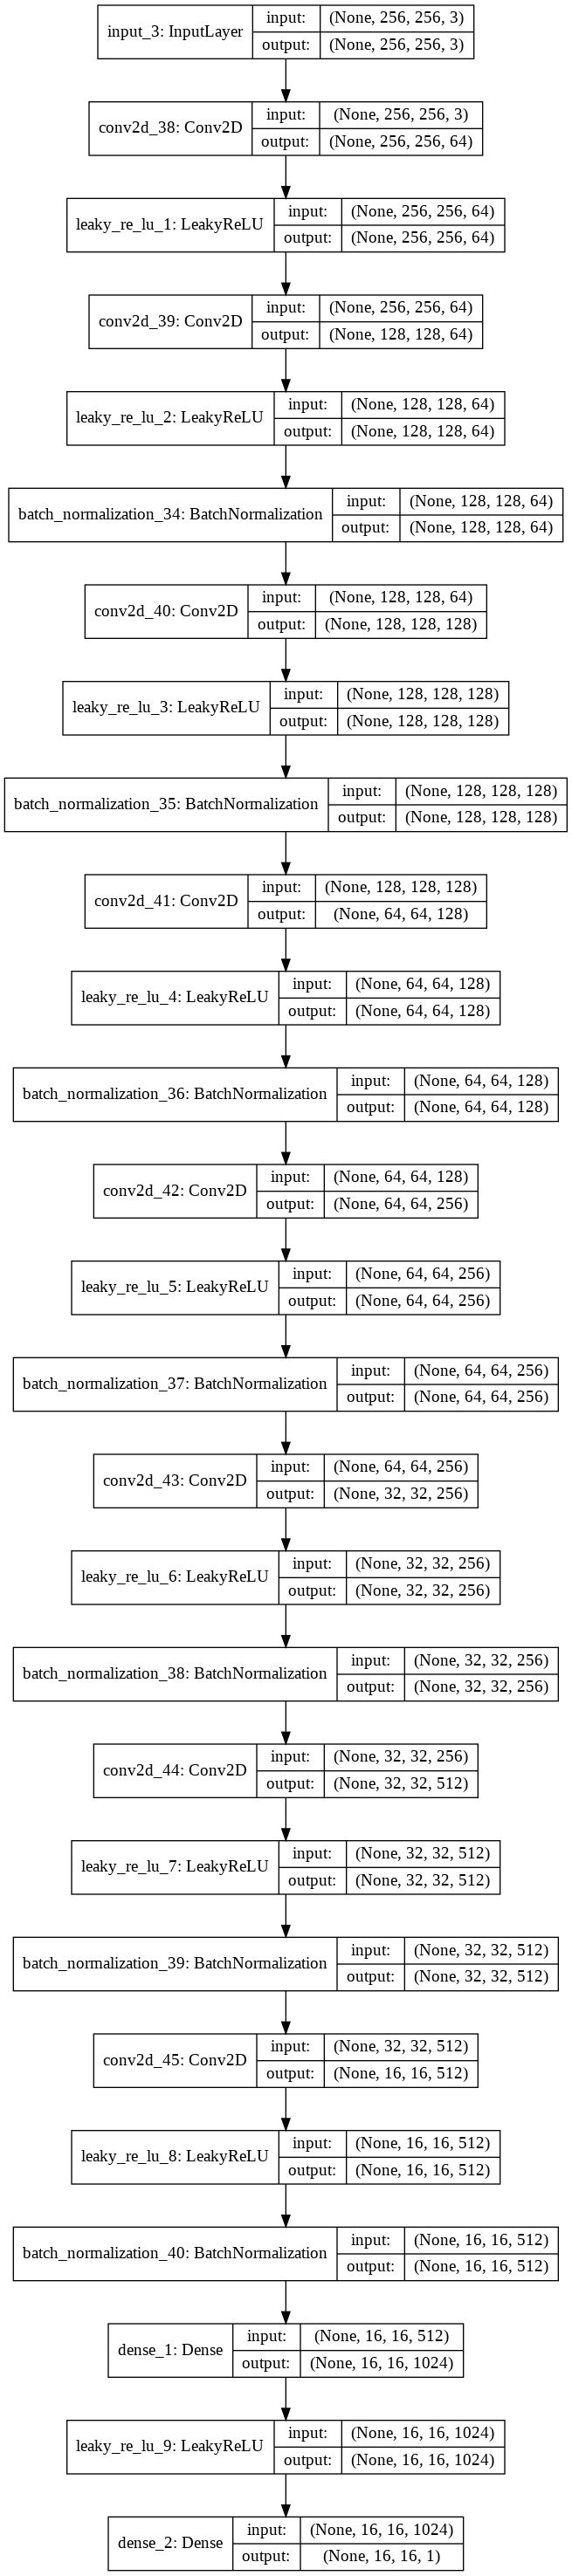

In [ ]:
plot_model(discriminator, to_file="discriminator.png", show_shapes=True)
display(IPythonImage('discriminator.png'))

In [ ]:
fe_model = build_VGG19()
fe_model.trainable = False
fe_model.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

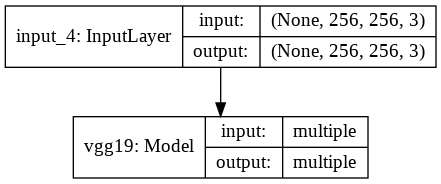

In [ ]:
plot_model(fe_model, to_file="fe_model.png", show_shapes=True)
display(IPythonImage('fe_model.png'))

In [ ]:
adversarial_model = build_adversarial_model(generator, discriminator, fe_model)

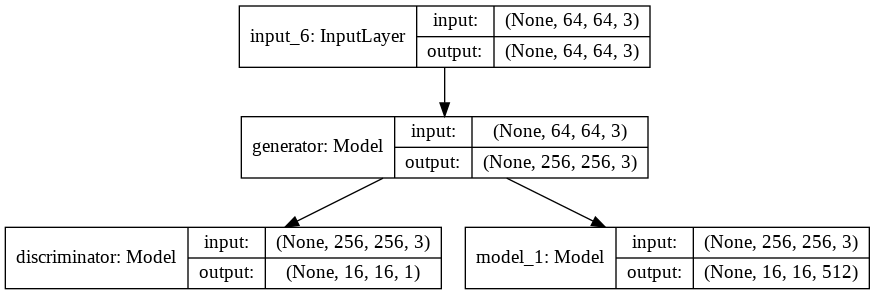

In [ ]:
plot_model(adversarial_model, to_file="adversarial_model.png", show_shapes=True)
display(IPythonImage('adversarial_model.png'))

Epoch 1/100
@Epoch: 1	D_loss: 0.38332176208496094	G_loss: [1.7938824, 0.60987806, 1.7932725]	PSNR:-0.13676753640174866	SSIM:0.03502703085541725
______________________________
Epoch 2/100
@Epoch: 2	D_loss: 0.39193010330200195	G_loss: [1.2200601, 0.60885483, 1.2194513]	PSNR:3.0552377700805664	SSIM:0.011630076915025711
______________________________
Epoch 3/100
@Epoch: 3	D_loss: 0.39812907576560974	G_loss: [1.0666269, 0.6148074, 1.0660121]	PSNR:2.3300442695617676	SSIM:-0.011881772428750992
______________________________
Epoch 4/100
@Epoch: 4	D_loss: 0.3947535753250122	G_loss: [1.4823235, 0.60128427, 1.4817222]	PSNR:0.8331092596054077	SSIM:0.008428376168012619
______________________________
Epoch 5/100
@Epoch: 5	D_loss: 0.385556697845459	G_loss: [1.8366282, 0.6094258, 1.8360188]	PSNR:0.7774090766906738	SSIM:0.01432516798377037
______________________________
Epoch 6/100
@Epoch: 6	D_loss: 0.39331427216529846	G_loss: [1.1699413, 0.603583, 1.1693377]	PSNR:0.05528244376182556	SSIM:-0.0185680091

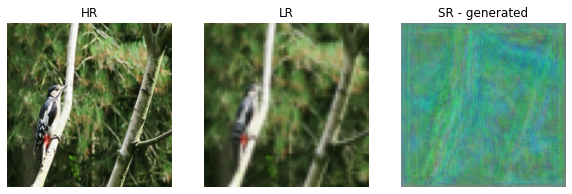

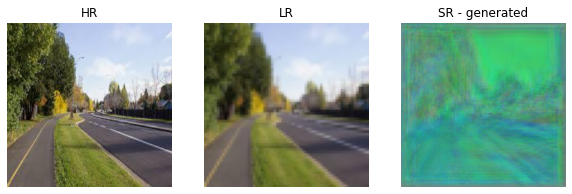

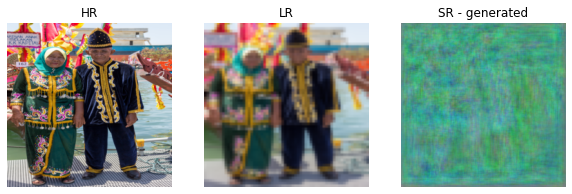

In [ ]:
start = time.time()
generator ,discriminator,adversarial,losses,psnr,ssim = train(epochs=100 , batch_size=batch_size)
stop = time.time()
print(f"Total_Time is :{(stop-start)} Seconds \t\t {(stop-start)/60} minutes")

In [ ]:
generator.save("/content/drive/MyDrive/Output/Try22_12_2021_Seb/Final_model.h5")
discriminator.save("/content/drive/MyDrive/Output/Try22_12_2021_Seb/srgan_discriminator_model.h5")
adversarial.save("/content/drive/MyDrive/Output/Try22_12_2021_Seb/srgan_adversarial_model.h5")

In [ ]:
# plots - post training
plot_loss(losses)
plot_psnr(psnr)
plot_ssim(ssim)

In [ ]:
import gdown
# https://drive.google.com/file/d/116fpSp3dUBtH7GkCoZ4UymK76xRTrZLs/view?usp=sharing
url = 'https://drive.google.com/uc?id=116fpSp3dUBtH7GkCoZ4UymK76xRTrZLs'
output = 'generator_model.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=116fpSp3dUBtH7GkCoZ4UymK76xRTrZLs
To: /content/generator_model.h5
100%|██████████| 8.49M/8.49M [00:00<00:00, 36.5MB/s]


'generator_model.h5'

In [ ]:
model =load_model("/content/generator_model.h5")

NameError: ignored

#Prediction

In [ ]:
def SRGAN_predict(lr_image_path):
  img =lr_image_path 
  lr_images = sample_images_test(img)
  # normalize the images
  lr_images = lr_images / 127.5 - 1.

  generated_images = model.predict_on_batch(lr_images)
  lr_images2 = lr_images.reshape((64,64,3))
  generated_images2= generated_images.reshape((256,256,3))

  # save_images_test(lr_images2 , generated_images2, "/content/test.png")
  return generated_images2


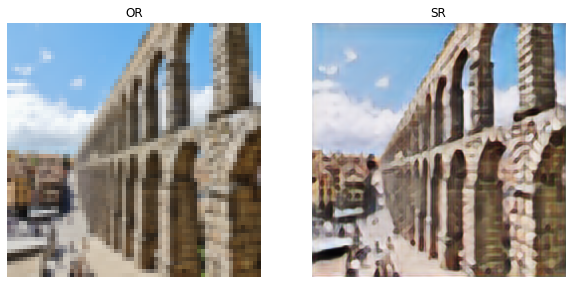

In [ ]:
img_path ="/content/high_resolution/0009.png"
generated_Image = SRGAN_predict(img_path)

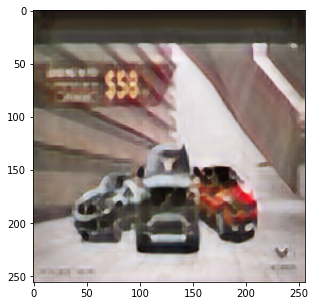

In [ ]:
lr_images,generated_images = SRGAN_predict("/content/5.png", "/content/generator_model.h5")	
show_image(generated_images)

#Load saved Model and Predict

In [ ]:
model =load_model('/content/drive/MyDrive/Output/Try22_12_2021_Seb/Final_model.h5')

In [ ]:
img ="/content/high_resolution/25.png"
lr_img = sample_images_test(img)
# normalize the images
lr_img = lr_img / 127.5 - 1.
generated_img = model.predict_on_batch(lr_img)
lr_images_saved_m = lr_img.reshape((64,64,3))
generated_images_saved_m= generated_img.reshape((256,256,3))
save_images_test(lr_images_saved_m ,generated_images_saved_m ,"/content/")

#Deploy by Streamlit

In [ ]:
# %%capture
# !pip install keras==2.3.1
# !pip install tensorflow_gpu==2.1.0
# !apt-get -qq install -y graphviz && pip install -q pydot
# !pip install h5py==2.10.0 
# VGG19_base = VGG19(weights="imagenet")
%%writefile app.py
import streamlit as st 
from PIL import Image
import numpy as np
import pandas as pd

import glob
import os

import random
from numpy import asarray
from itertools import repeat

import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model

def predict(img , model):
        lr_img = np.array(img)
        sr_img = model.predict_on_batch(np.array(lr_img)) 
        return (Image.fromarray(sr_img))


st.title("Super Resolution GAN ")
st.subheader("Upload an image which you want to upscale")   
st.spinner("Testing spinner")

uploaded_file = st.file_uploader("Choose an image...", type=("jpg", "png", "jpeg"))

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.')
    st.write("")
    if st.button('Upscale Now'):
        st.write("upscaling...") 
        pred = predict(image ,"generator_7500.h5" )
        st.image(pred, caption='Upscaled Image', use_column_width=True)        

Writing app.py


In [ ]:
# !pip install streamlit

In [ ]:
!streamlit run app.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.201.135.247:8501



# 			SRGAN Project Links:
	

1- Github :  https://github.com/AbdullahAbdelhakeem6484/ITI_Graduation_Project1_SISR_BY_GAN

2- website: https://srgan-iti.herokuapp.com/

3- Pip Package : https://pypi.org/project/SuperResolution-GANs/0.0.5/

4- Videos:
	1- Websites,github and pip : https://www.youtube.com/watch?v=hyrPd2dkM38
	2- Documents               : https://www.youtube.com/watch?v=94Mkvk4PLMk



#SRGAN_Package Test

In [ ]:
%%capture
!pip install keras==2.3.1
!pip install tensorflow_gpu==2.1.0
!apt-get -qq install -y graphviz && pip install -q pydot
!pip install h5py==2.10.0 

In [ ]:
import glob
import os
import time

import random
import numpy as np
from numpy import asarray
import pandas as pd
from itertools import repeat

import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard ,ModelCheckpoint
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense, Conv2D, UpSampling2D
from keras.models import Model,load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model


import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt

import pydot
from IPython.display import Image as IPythonImage

import warnings
warnings.filterwarnings("ignore")

In [ ]:
VGG19_base = VGG19(weights="imagenet")

In [ ]:
!pip install SuperResolution-GANs==0.0.4

In [ ]:
!pip install -r requirements_colab.txt

In [ ]:
import gdown
# https://drive.google.com/file/d/116fpSp3dUBtH7GkCoZ4UymK76xRTrZLs/view?usp=sharing
url = 'https://drive.google.com/uc?id=116fpSp3dUBtH7GkCoZ4UymK76xRTrZLs'
output = 'model.h5'
gdown.download(url, output, quiet=False)

In [ ]:
model =load_model("/content/model.h5")

In [ ]:
from super_resolution_gans import srgan_utils
LR_img,SR_img = srgan_utils.SRGAN_predict(lr_image_path="/content/88.png", model_path="model.h5")

In [ ]:
#Original Image (Low Resolution)
srgan_utils.show_image(SR_img)

#Thank You